# Overview — Java

Interactive summary of Java-centric findings using CSVs from `reports/java-csv/`.
This notebook uses **Plotly** visuals and robust column detection with safe fallbacks.

> This version includes special handling for **duplicate column names** in CSVs to avoid 2D selections causing errors.

In [1]:
# --- Imports & global theme ---
import os
from typing import List, Optional
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

pio.templates.default = 'plotly_white'

In [2]:
# --- Paths & CSV helpers ---
REPORTS_ROOT = os.environ.get('REPORTS_DIRECTORY', os.path.abspath(os.path.join(os.getcwd(), '..', 'reports')))
JAVA_DIR = os.path.join(REPORTS_ROOT, 'java-csv')
print('JAVA_DIR =', JAVA_DIR)

def csv_path(name: str) -> str:
    return os.path.join(JAVA_DIR, name)

def read_csv_or_empty(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        try:
            df = pd.read_csv(path, low_memory=False)
            # Drop duplicate column *names* to avoid 2D selections later; keep first occurrence
            if df.columns.duplicated().any():
                df = df.loc[:, ~df.columns.duplicated()]
            return df
        except Exception as e:
            print(f"[warn] Failed to read {path}: {e}")
            return pd.DataFrame()
    else:
        print(f"[warn] Missing CSV: {path}")
        return pd.DataFrame()

JAVA_DIR = /Users/jonathan.nervaez/Documents/AppModPractice/E2E-decomposition/reports/java-csv


In [3]:
# --- Column helpers & detection ---
def as_series_1d(obj) -> pd.Series:
    """Return a 1D Series from a Series/DataFrame/array-like, picking the **first column** when needed."""
    if isinstance(obj, pd.Series):
        return obj
    if isinstance(obj, pd.DataFrame):
        if obj.shape[1] == 0:
            return pd.Series([], dtype='float64')
        return obj.iloc[:, 0]
    return pd.Series(obj)

def to_numeric_series_safe(series_like) -> pd.Series:
    """Coerce any 1D series-like object to numeric; lists/arrays/dicts -> length; strings parsed as float."""
    series = as_series_1d(series_like)
    def coerce_one(x):
        if x is None:
            return np.nan
        if isinstance(x, (int, float, np.number)):
            return float(x)
        if isinstance(x, (list, tuple, set, dict, np.ndarray)):
            return float(len(x))
        s = str(x).strip().replace(',', '')
        try:
            return float(s)
        except Exception:
            return np.nan
    return series.map(coerce_one)

def pick_first(df: pd.DataFrame, candidates: List[str], kind: Optional[str] = None) -> Optional[str]:
    if df.empty:
        return None
    if kind is None:
        for c in candidates:
            if c in df.columns:
                return c
        return None
    if kind == 'numeric':
        for c in df.columns:
            if pd.api.types.is_numeric_dtype(df[c]):
                return c
        for c in df.columns:
            try:
                if pd.to_numeric(df[c], errors='coerce').notna().any():
                    return c
            except Exception:
                if to_numeric_series_safe(df[c]).notna().any():
                    return c
        return None
    if kind == 'text':
        for c in df.columns:
            if not pd.api.types.is_numeric_dtype(df[c]):
                return c
        return None
    return None

def find_artifact_col(df: pd.DataFrame) -> Optional[str]:
    prefs = ['artifactName','artifact.fileName','artifact','fileName','filename','name']
    for c in prefs:
        if c in df.columns:
            return c
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]) and df[c].notna().sum() >= 2:
            return c
    return None

def find_numeric_col(df: pd.DataFrame, preferred=None, exclude=None) -> Optional[str]:
    preferred = preferred or []
    exclude = set(exclude or [])
    for c in preferred:
        if c in df.columns and c not in exclude:
            return c
    for c in df.columns:
        if c in exclude:
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
    for c in df.columns:
        if c in exclude:
            continue
        try:
            if pd.to_numeric(df[c], errors='coerce').notna().any():
                return c
        except Exception:
            if to_numeric_series_safe(df[c]).notna().any():
                return c
    return None

In [4]:
# --- Plot helpers (duplicate-safe) ---
def select_first_col(df: pd.DataFrame, colname: str) -> pd.Series:
    """Select the first occurrence if there are duplicate column names."""
    if colname not in df.columns:
        return pd.Series([], dtype='float64')
    # loc[:, [colname]] returns all duplicates as DataFrame; take the first column
    return df.loc[:, [colname]].iloc[:, 0]

def bar_smart_clean(df: pd.DataFrame, name_col: Optional[str], value_col: Optional[str], title: str, ylabel: str, top_n: int = 20):
    if df.empty or not name_col or not value_col or name_col not in df.columns or value_col not in df.columns:
        print(f"[info] {title}: missing columns or empty data.")
        return
    names = select_first_col(df, name_col).astype(str)
    values = to_numeric_series_safe(select_first_col(df, value_col))
    sub = pd.DataFrame({name_col: names, value_col: values})
    sub = sub.dropna(subset=[value_col])
    sub = sub[sub[name_col].str.strip().ne('')]
    if sub.empty:
        print(f"[info] {title}: no rows to plot after cleaning.")
        return
    sub = sub.sort_values(value_col, ascending=False).head(top_n)
    fig = px.bar(sub, x=name_col, y=value_col, title=title, labels={name_col: '', value_col: ylabel})
    fig.update_layout(xaxis_tickangle=-60, height=420, margin=dict(l=20,r=20,t=60,b=40))
    fig.show()

def pie_top_donut(df: pd.DataFrame, name_col: Optional[str], value_col: Optional[str], title: str, top_n: int = 12, others_label: str = 'others'):
    if df.empty or not name_col or not value_col or name_col not in df.columns or value_col not in df.columns:
        print(f"[info] {title}: missing columns or empty data.")
        return
    names = select_first_col(df, name_col).astype(str)
    values = to_numeric_series_safe(select_first_col(df, value_col)).fillna(0)
    work = pd.DataFrame({name_col: names, value_col: values})
    work = work.sort_values(value_col, ascending=False)
    top = work.head(top_n)
    if len(work) > top_n:
        rest = work.iloc[top_n:][value_col].sum()
        top = pd.concat([top, pd.DataFrame({name_col:[others_label], value_col:[rest]})], ignore_index=True)
    fig = px.pie(top, names=name_col, values=value_col, title=title, hole=0.45)
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.update_layout(height=520, margin=dict(l=20,r=20,t=60,b=20))
    fig.show()

## Load CSVs

In [5]:
df_annotations              = read_csv_or_empty(csv_path('AnnotatedCodeElements.csv'))
df_annotations_per_artifact = read_csv_or_empty(csv_path('AnnotatedCodeElementsPerArtifact.csv'))
df_reflection               = read_csv_or_empty(csv_path('ReflectionUsage.csv'))
df_reflection_detailed      = read_csv_or_empty(csv_path('ReflectionUsageDetailed.csv'))
df_deprecated               = read_csv_or_empty(csv_path('DeprecatedElementUsage.csv'))
df_deprecated_detailed      = read_csv_or_empty(csv_path('DeprecatedElementUsageDetailed.csv'))
df_spring_web               = read_csv_or_empty(csv_path('Spring_Web_Request_Annotations.csv'))
df_jakarta_rest             = read_csv_or_empty(csv_path('JakartaEE_REST_Annotations.csv'))

print('Shapes:')
for name, df in [
    ('AnnotatedCodeElements', df_annotations),
    ('AnnotatedCodeElementsPerArtifact', df_annotations_per_artifact),
    ('ReflectionUsage', df_reflection),
    ('ReflectionUsageDetailed', df_reflection_detailed),
    ('DeprecatedElementUsage', df_deprecated),
    ('DeprecatedElementUsageDetailed', df_deprecated_detailed),
    ('Spring_Web_Request_Annotations', df_spring_web),
    ('JakartaEE_REST_Annotations', df_jakarta_rest),
]:
    print(f' - {name}:', df.shape)

Shapes:
 - AnnotatedCodeElements: (829, 5)
 - AnnotatedCodeElementsPerArtifact: (829, 6)
 - ReflectionUsage: (1, 5)
 - ReflectionUsageDetailed: (3418, 4)
 - DeprecatedElementUsage: (8, 5)
 - DeprecatedElementUsageDetailed: (7850, 5)
 - Spring_Web_Request_Annotations: (332, 8)
 - JakartaEE_REST_Annotations: (0, 7)


## 1) Annotations

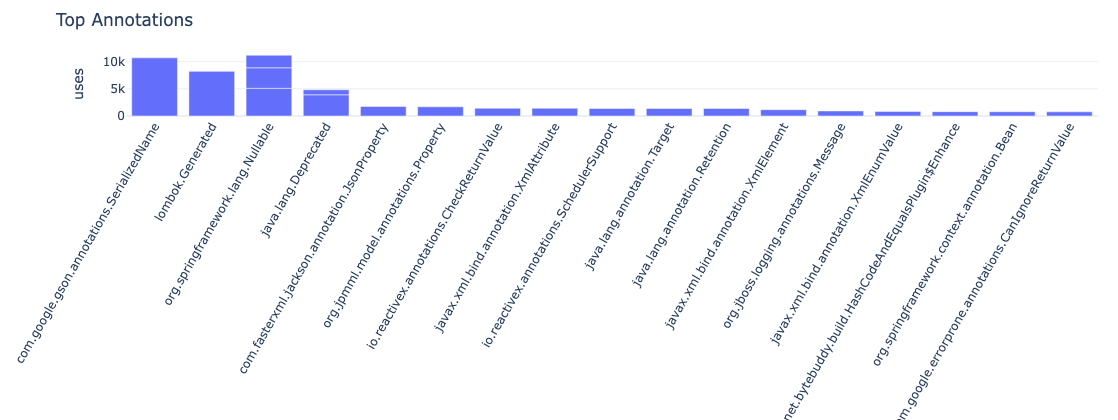

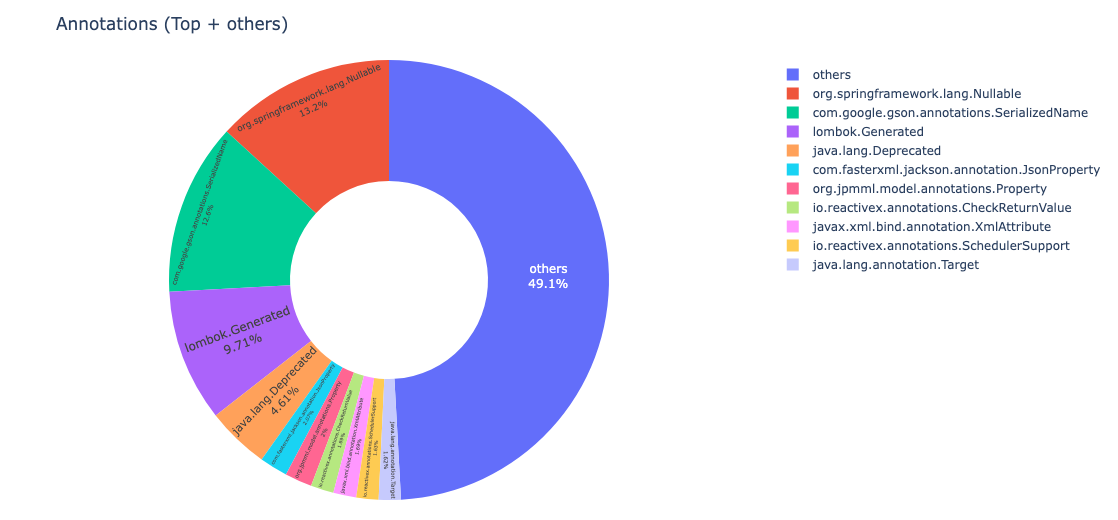

In [6]:
# Overall top annotations
if not df_annotations.empty:
    ann_col = pick_first(df_annotations, ['annotation','Annotation','AnnotationName'], None) or pick_first(df_annotations, [], 'text')
    cnt_col = pick_first(df_annotations, ['count','occurrences','uses'], None) or pick_first(df_annotations, [], 'numeric')
    if ann_col and cnt_col:
        top = df_annotations.sort_values(cnt_col, ascending=False).head(20)
        bar_smart_clean(top, ann_col, cnt_col, 'Top Annotations', 'uses')
        pie_top_donut(df_annotations, ann_col, cnt_col, 'Annotations (Top + others)')
    else:
        print('[info] AnnotatedCodeElements: required columns not found.')
else:
    print('[info] AnnotatedCodeElements.csv not found or empty.')

In [7]:
# Annotations per artifact (with fallback aggregation)
if not df_annotations_per_artifact.empty:
    art_col = find_artifact_col(df_annotations_per_artifact)
    cnt_col = pick_first(df_annotations_per_artifact, ['count','uses','occurrences'], None)
    if not cnt_col:
        cnt_col = find_numeric_col(df_annotations_per_artifact, preferred=['count','uses','occurrences'], exclude=[art_col])

    if not cnt_col and art_col:
        tmp = df_annotations_per_artifact.copy()
        tmp[art_col] = tmp[art_col].astype(str)
        tmp = tmp[tmp[art_col].str.strip().ne('')]
        agg = tmp.groupby(art_col).size().reset_index(name='annotationUses')
        bar_smart_clean(agg, art_col, 'annotationUses', 'Annotations per Artifact', 'uses')
    else:
        bar_smart_clean(df_annotations_per_artifact, art_col or 'artifactName', cnt_col or 'count', 'Annotations per Artifact', 'uses')
else:
    print('[info] AnnotatedCodeElementsPerArtifact.csv not found or empty.')

## 2) Reflection

In [8]:
# Reflection summary
if not df_reflection.empty:
    name_col = pick_first(df_reflection, ['artifactName','package','Package','type','Type'], None) or pick_first(df_reflection, [], 'text')
    cnt_col  = pick_first(df_reflection, ['count','uses','occurrences','calls','members'], None) or pick_first(df_reflection, [], 'numeric')
    bar_smart_clean(df_reflection, name_col, cnt_col, 'Reflection Usage (Top)', 'occurrences')
else:
    print('[info] ReflectionUsage.csv not found or empty.')

[info] Reflection Usage (Top): no rows to plot after cleaning.


In [9]:
# Reflection hotspots (detailed)
if not df_reflection_detailed.empty:
    name_col = pick_first(df_reflection_detailed, ['Member','member','Method','method','Type','type','Class','class','Target'], None) or pick_first(df_reflection_detailed, [], 'text')
    cnt_col  = pick_first(df_reflection_detailed, ['count','uses','occurrences'], None) or pick_first(df_reflection_detailed, [], 'numeric')
    bar_smart_clean(df_reflection_detailed, name_col, cnt_col, 'Reflection Hotspots (Top)', 'uses')
else:
    print('[info] ReflectionUsageDetailed.csv not found or empty.')

[info] Reflection Hotspots (Top): no rows to plot after cleaning.


## 3) Web endpoints (Spring / Jakarta)

In [10]:
# Spring web request annotations
if not df_spring_web.empty:
    ann_col = pick_first(df_spring_web, ['annotation','Annotation','AnnotationName'], None) or pick_first(df_spring_web, [], 'text')
    cnt_col = pick_first(df_spring_web, ['count','occurrences','uses'], None) or pick_first(df_spring_web, [], 'numeric')
    bar_smart_clean(df_spring_web, ann_col, cnt_col, 'Spring Web Request Annotations (Top)', 'uses')
else:
    print('[info] Spring_Web_Request_Annotations.csv not found or empty.')

[info] Spring Web Request Annotations (Top): no rows to plot after cleaning.


In [11]:
# Jakarta REST annotations
if not df_jakarta_rest.empty:
    ann_col = pick_first(df_jakarta_rest, ['annotation','Annotation','AnnotationName'], None) or pick_first(df_jakarta_rest, [], 'text')
    cnt_col = pick_first(df_jakarta_rest, ['count','occurrences','uses'], None) or pick_first(df_jakarta_rest, [], 'numeric')
    bar_smart_clean(df_jakarta_rest, ann_col, cnt_col, 'Jakarta REST Annotations (Top)', 'uses')
else:
    print('[info] JakartaEE_REST_Annotations.csv not found or empty.')

[info] JakartaEE_REST_Annotations.csv not found or empty.


## Appendix — Quick schema inspection
Use this to inspect column names if any chart looks odd; adjust detection logic accordingly.

In [12]:
def inspect(df: pd.DataFrame, name: str):
    print('\n---', name, '---')
    if df.empty:
        print('(empty)'); return
    print('columns:', list(df.columns))
    display(df.head(5))
    print(df.info())

inspect(df_annotations, 'AnnotatedCodeElements')
inspect(df_annotations_per_artifact, 'AnnotatedCodeElementsPerArtifact')
inspect(df_reflection, 'ReflectionUsage')
inspect(df_reflection_detailed, 'ReflectionUsageDetailed')
inspect(df_deprecated, 'DeprecatedElementUsage')
inspect(df_deprecated_detailed, 'DeprecatedElementUsageDetailed')
inspect(df_spring_web, 'Spring_Web_Request_Annotations')
inspect(df_jakarta_rest, 'JakartaEE_REST_Annotations')


--- AnnotatedCodeElements ---
columns: ['annotationName', 'languageElement', 'numberOfAnnotatedElements', 'examples', 'Source Cypher File: Java/Annotated_code_elements.cypher']


,annotationName,languageElement,numberOfAnnotatedElements,examples,Source Cypher File: Java/Annotated_code_elements.cypher
0,com.google.gson.annotations.SerializedName,Field,10699,"com.stripe.model.Account$BusinessProfile.mcc,c...",NaN
1,lombok.Generated,Method,8214,com.stripe.exception.CardException.getDeclineC...,NaN
2,org.springframework.lang.Nullable,Parameter,5097,org.springframework.jdbc.core.JdbcTemplate$1Ba...,NaN
3,java.lang.Deprecated,Method,3903,org.springframework.boot.loader.Launcher.creat...,NaN
4,org.springframework.lang.Nullable,Method,3772,com.salesmanager.shop.store.controller.shoppin...,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   annotationName                                           829 non-null    object 
 1   languageElement                                          829 non-null    object 
 2   numberOfAnnotatedElements                                829 non-null    int64  
 3   examples                                                 829 non-null    object 
 4   Source Cypher File: Java/Annotated_code_elements.cypher  0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 32.5+ KB
None

--- AnnotatedCodeElementsPerArtifact ---
columns: ['artifactName', 'annotationName', 'languageElement', 'numberOfAnnotatedElements', 'examples', 'Source Cypher File: Java/Annotated_code_elements_per_artifact.cypher']


,artifactName,annotationName,languageElement,numberOfAnnotatedElements,examples,Source Cypher File: Java/Annotated_code_elements_per_artifact.cypher
0,NaN,com.google.gson.annotations.SerializedName,Field,10699,"com.stripe.model.Account$BusinessProfile.mcc,c...",NaN
1,NaN,lombok.Generated,Method,8214,com.stripe.exception.CardException.getDeclineC...,NaN
2,NaN,org.springframework.lang.Nullable,Parameter,5097,org.springframework.jdbc.core.JdbcTemplate$1Ba...,NaN
3,NaN,java.lang.Deprecated,Method,3903,org.springframework.boot.loader.Launcher.creat...,NaN
4,NaN,org.springframework.lang.Nullable,Method,3772,com.salesmanager.shop.store.controller.shoppin...,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 6 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   artifactName                                                          0 non-null      float64
 1   annotationName                                                        829 non-null    object 
 2   languageElement                                                       829 non-null    object 
 3   numberOfAnnotatedElements                                             829 non-null    int64  
 4   examples                                                              829 non-null    object 
 5   Source Cypher File: Java/Annotated_code_elements_per_artifact.cypher  0 non-null      float64
dtypes: float64(2), int64(1), object(3)
memory usage: 39.0+ KB
None

--- ReflectionUsage ---
columns: ['

,dependentArtifactName,numberOfReflectionCaller,someReflectionCaller,someReflectionTypes,Source Cypher File: Java/Java_Reflection_usage.cypher
0,NaN,91774,com.salesmanager.core.business.configuration.P...,"java.lang.reflect.ParameterizedType,java.lang....",NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   dependentArtifactName                                  0 non-null      float64
 1   numberOfReflectionCaller                               1 non-null      int64  
 2   someReflectionCaller                                   1 non-null      object 
 3   someReflectionTypes                                    1 non-null      object 
 4   Source Cypher File: Java/Java_Reflection_usage.cypher  0 non-null      float64
dtypes: float64(2), int64(1), object(2)
memory usage: 172.0+ bytes
None

--- ReflectionUsageDetailed ---
columns: ['dependentArtifactName', 'reflectionCallerTypeName', 'reflectionTypes', 'Source Cypher File: Java/Java_Reflection_usage_detailed.cypher']


,dependentArtifactName,reflectionCallerTypeName,reflectionTypes,Source Cypher File: Java/Java_Reflection_usage_detailed.cypher
0,NaN,com.salesmanager.core.business.services.common...,java.lang.reflect.ParameterizedType,NaN
1,NaN,com.zaxxer.hikari.util.PropertyElf,"java.lang.reflect.Constructor,java.lang.reflec...",NaN
2,NaN,com.zaxxer.hikari.util.DriverDataSource,java.lang.reflect.Constructor,NaN
3,NaN,com.zaxxer.hikari.pool.ProxyConnection$ClosedC...,"java.lang.reflect.Proxy,java.lang.reflect.Method",NaN
4,NaN,com.zaxxer.hikari.util.JavassistProxyFactory,"java.lang.reflect.Method,java.lang.reflect.Array",NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3418 entries, 0 to 3417
Data columns (total 4 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   dependentArtifactName                                           0 non-null      float64
 1   reflectionCallerTypeName                                        3418 non-null   object 
 2   reflectionTypes                                                 3418 non-null   object 
 3   Source Cypher File: Java/Java_Reflection_usage_detailed.cypher  0 non-null      float64
dtypes: float64(2), object(2)
memory usage: 106.9+ KB
None

--- DeprecatedElementUsage ---
columns: ['artifactName', 'deprecatedElement', 'numberOfElementsUsingDeprecatedElements', 'someElementsUsingDeprecatedElements', 'Source Cypher File: Java/Java_deprecated_element_usage.cypher']


,artifactName,deprecatedElement,numberOfElementsUsingDeprecatedElements,someElementsUsingDeprecatedElements,Source Cypher File: Java/Java_deprecated_element_usage.cypher
0,NaN,Method,1587,com.salesmanager.shop.store.facade.content.Con...,NaN
1,NaN,Class,963,com.salesmanager.shop.store.controller.shoppin...,NaN
2,NaN,Field,1195,org.hibernate.type.descriptor.sql.spi.SqlTypeD...,NaN
3,NaN,Interface,564,"org.hibernate.type.SetType,org.hibernate.type....",NaN
4,NaN,Constructor,98,"org.hibernate.type.ManyToOneType.<init>,org.hi...",NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   artifactName                                                   0 non-null      float64
 1   deprecatedElement                                              8 non-null      object 
 2   numberOfElementsUsingDeprecatedElements                        8 non-null      int64  
 3   someElementsUsingDeprecatedElements                            8 non-null      object 
 4   Source Cypher File: Java/Java_deprecated_element_usage.cypher  0 non-null      float64
dtypes: float64(2), int64(1), object(2)
memory usage: 452.0+ bytes
None

--- DeprecatedElementUsageDetailed ---
columns: ['artifactName', 'deprecatedElementType', 'elementUsingDeprecatedElement', 'deprecatedElement', 'Source Cypher File: Java/Java_deprecat

,artifactName,deprecatedElementType,elementUsingDeprecatedElement,deprecatedElement,Source Cypher File: Java/Java_deprecated_element_usage_detailed.cypher
0,NaN,Method,aj.org.objectweb.asm.MethodVisitor.visitMethod...,"void visitMethodInsn(int,java.lang.String,java...",NaN
1,NaN,Interface,com.amazonaws.AmazonWebServiceClient,com.amazonaws.handlers.RequestHandler,NaN
2,NaN,Parameter,com.amazonaws.AmazonWebServiceClient.endClient...,NaN,NaN
3,NaN,Class,com.amazonaws.AmazonWebServiceRequest,com.amazonaws.internal.StaticCredentialsProvider,NaN
4,NaN,Constructor,com.amazonaws.auth.InstanceProfileCredentialsP...,void <init>(),NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7850 entries, 0 to 7849
Data columns (total 5 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   artifactName                                                            0 non-null      float64
 1   deprecatedElementType                                                   7850 non-null   object 
 2   elementUsingDeprecatedElement                                           7850 non-null   object 
 3   deprecatedElement                                                       7849 non-null   object 
 4   Source Cypher File: Java/Java_deprecated_element_usage_detailed.cypher  0 non-null      float64
dtypes: float64(2), object(3)
memory usage: 306.8+ KB
None

--- Spring_Web_Request_Annotations ---
columns: ['path', 'httpMethod', 'resourceArtifact', 'resourceType', 'resourceMethod', 'a

,path,httpMethod,resourceArtifact,resourceType,resourceMethod,additionalHttpProperties,methodParameters,Source Cypher File: Java/Spring_Web_Request_Annotations.cypher
0,${server.error.path:${error.path:/error}}/,ALL,NaN,org.springframework.boot.autoconfigure.web.ser...,error,NaN,NaN,NaN
1,${server.error.path:${error.path:/error}}/,ALL,NaN,org.springframework.boot.autoconfigure.web.ser...,errorHtml,"produces: text/html,produces: text/html,produc...",NaN,NaN
2,/,ALL,NaN,com.salesmanager.shop.store.api.exception.Rest...,handleServiceException,"produces: application/json,produces: applicati...",NaN,NaN
3,/,ALL,NaN,com.salesmanager.shop.store.api.exception.Rest...,handleRestApiException,"produces: application/json,produces: applicati...",NaN,NaN
4,/,GET,NaN,com.salesmanager.shop.store.api.DefaultController,version,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 8 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   path                                                            332 non-null    object 
 1   httpMethod                                                      332 non-null    object 
 2   resourceArtifact                                                0 non-null      float64
 3   resourceType                                                    332 non-null    object 
 4   resourceMethod                                                  332 non-null    object 
 5   additionalHttpProperties                                        95 non-null     object 
 6   methodParameters                                                81 non-null     object 
 7   Source Cypher File: Java/Spring_Web_Request_Annotation